***
# Sentiment Analysis

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called sentiment analysis. In this notebook you will build an end-to-end sentiment classification system from scratch.

***

What will be doing in the notebook
* Exploring the dataset ( here we will be using the <a href="https://ai.stanford.edu/~amaas/data/sentiment/" tagret="_blank" > IMDb dataset </a> )
    * It consists of movie reviews from <a href="https://imdb.com" target="_blank"> imdb.com </a> where each comment is labeled as either 'positive', if the reviewer enjoyed the movie or 'negative', otherwise.
    * It can be found in the 'data' subdirectory of this folder

<br>

* Preprocessing this given data according to our needs
    * Since it contains unnecessary HTML tags, stop words, non-letter characters

<br>

* Extracting the Bag of Words (BoG) features from the preprocessed data ( using CounterVectorizer from <a href="https://scikit-learn.org/stable/"> scikit learn library</a>)

<br>

* Classifying the comments using the Bag of Words feature implemented above ( mainly by using the Naive Bayes Classifier ( as done in the spam classifier project ))

<br>

* Since Bag of Words feature is a very basic approach that can be fooled easily, we will then be using Recurrent Neural Networks to improve our sentimental analyser


***



In [26]:
!pip3 install nltk 
import nltk
! pip3 install wordcloud
! pip3 install sklearn

! pip3 install nltk

nltk.download('stopwords')


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amnesia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Exploring the dataset

In [27]:
from cProfile import label
import os
import glob  # helps in returning all file paths that match a specific pattern


def read_imdb_data(data_dir='data/imdb-reviews'):
    """
    Functions to the read IMDB movie reviews from the given directory and return them along with their respective labes

    'data' directory structure explained
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    """

    # the structure will be
    # {'train' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}, 'test' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}}
    data = {}  # to store the reviews
    labels = {}  # to store the respective label of the reviews (pos or neg)

    # will recurse in the train and test subdirecotries in the data folder
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # further to recurse in the subdirectories of train and test
        for sentiment in ['pos', 'neg']:
            # list to store all the reviews
            data[data_type][sentiment] = []

            # lis to store the respective tags to all those reviews
            labels[data_type][sentiment] = []

            # fetching the list of all the files for that data type and sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            # returns the list of paths matching the pathname ( for example here the path name is data/imdb-reviews/train/pos/0_9.txt)
            files = glob.glob(path)

            # now since files is a list to all the pathnames of the files in the folder, we will recurse through all the files and store their data in data and their respective labels in labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment]. append(review.read())
                    labels[data_type][sentiment].append(sentiment)

            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                "{}/{} data size does not match labels size".format(
                    data_type, sentiment)

    return data, labels


In [28]:
# since we have mentioned th edefault direcotry path in the definition of the function itself, we do not need to write it again, unless we want to provide a different directory name
data, labels = read_imdb_data()

print("IMDB reviews : train = {} pos / {} neg, test = {} pos / {} neg". format(len(data['train']['pos']), len(data['train']['neg']),
                                                                               len(data['test']['pos']), len(data['test']['neg'])))


print("\n\n--- HERE IS A POSITIVE TRAINING DATA SET REVIEW ----\n",
      data['train']['pos'][2])
print("\n\n--- HERE IS A NEGATIVE TRAINING DATA SET REVIEW ----\n",
      data['train']['neg'][2])


IMDB reviews : train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


--- HERE IS A POSITIVE TRAINING DATA SET REVIEW ----
 "Holes" is my all-time favorite movie! So far I have seen this movie three times in theaters and am looking forward to purchasing it on DVD this upcoming September. I read the book after seeing the movie and was amazed at how alike the book and movie were. The director of this film did an excellent job of re-creating the book into movie form. Also, all of the actors selected to play the roles did wonderful playing their characters, especially Max Kasch as ZigZag. Props to all those involved in making this movie, it was a real success! 10 out of 10 stars, I definitely recommend it for everyone to see!


--- HERE IS A NEGATIVE TRAINING DATA SET REVIEW ----
 This budget-starved Italian action/sci-fi hybrid features David Warbeck as a Miami reporter who is chosen by the ghosts of the people of Atlantis (!) to stop an evil businessman (Academy Award nominee John

### Wordcloud visualization of words in the positive and negative training sets

 >  pos  reviews wordcloud:


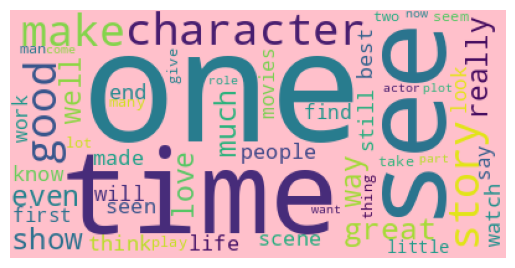

 >  neg  reviews wordcloud:


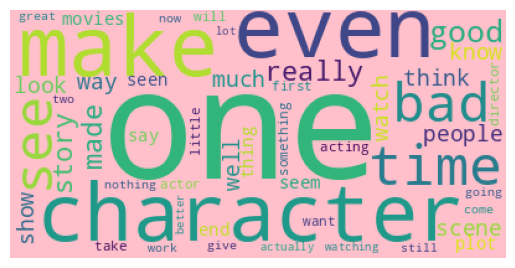

In [29]:

from wordcloud import WordCloud, STOPWORDS
from ossaudiodev import SOUND_MIXER_LINE1
import matplotlib.pyplot as plt
%matplotlib inline


sent = ['pos', 'neg']

for sentiment in sent:
    combined_text = " ".join([review for review in data['train'][sentiment]])
    # updating STOPWORDS with words like movie and film so that they do not show up in the wordcloud along with other stopwords
    wc = WordCloud(background_color='pink', max_words=50,
                   stopwords=STOPWORDS.update(['br', 'movie', 'film', 'films']))

    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    print(" > ", sentiment, " reviews wordcloud:")
    plt.show()


***
### Combining the negative and positive documents to get one unified training and testing set for further use

***

In [30]:
from sklearn.utils import shuffle
import random
from pprint import pprint


def prepare_imdb_data(data):
    """
    Preparing the training and testing sets from the files
    """
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []
    train_tuple = []
    test_tuple = []
    # Combining the negative and positive labeled data into one unified data
    for sentiment in data['train']:
        for review in data['train'][sentiment]:
            train_tuple.append((review, sentiment))

    for sentiment in data['test']:
        for review in data['test'][sentiment]:
            test_tuple.append((review, sentiment))

    train_tuple = shuffle(train_tuple, random_state=1)
    test_tuple = shuffle(test_tuple, random_state=1)
    for item in train_tuple:
        data_train.append(item[0])
        labels_train.append(item[1])

    for item in test_tuple:
        data_test.append(item[0])
        labels_test.append(item[1])

    return data_train, data_test, labels_train, labels_test


In [31]:
data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(
    len(data_train), len(data_test)))

for i in range(len(data_train)):
    if i > 5:
        break
    print(labels_train[i])


IMDb reviews (combined): train = 25000, test = 25000
neg
pos
neg
neg
pos
pos


***
## Preprocessing(/cleaning) the data 

Our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

***

In [32]:
from html.entities import html5
from tracemalloc import stop
from bs4 import BeautifulSoup  # to help in rremoving the HTML tags
import re  # for helping in removing the non-letter characters
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

stopwords_list = stopwords.words('english')


def review_to_words(review):
    """
    Converting the raw review strings to a sequence of clean words
    """
    # removing the html tags
    soup = BeautifulSoup(review, 'html5')
    clean = soup.get_text()

    # converting the string to a list
    clean_list = clean.split()

    # to remove the non-letter words
    for i in range(len(clean_list)):
        clean_list[i] = re.sub('[^a-zA-Z ]', '', clean_list[i])

    # removing the stopwords
    clean_list = [i for i in clean_list if i not in stopwords_list]

    # converting to lower case
    clean_list = [i.lower() for i in clean_list]

    # stemming the words in the corpus
    clean = [stemmer.stem(i) for i in clean_list]

    return clean

# print(review_to_words("""This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"""))


### Creating a cache file to store the cleaned reviews temporarily
With the function review_to_words() fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [33]:
import pickle

# this folder will store the cache files
cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)  # ensure that the directory exists


# pickle files have the extension ".pkl"
def preprocess_data(data_train, data_test, labels_train, labels_test, cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """
    Convert each review to words
    Read from cache if available
    """

    # checks if the cache file is empty, if not then read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)

            print(
                " Reading preprocessed data from the pre-existing cache file:", cache_file)
        except:
            pass  # if not able to read cache still it is fine.

    # if there is no previous cache file, then do heavy-lifting
    if cache_data is None:

        # preprocess the training and testing data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))

        # Write to the cached file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)

            with open(os.path.join(cache_dir, cache_file), "wb")as f:
                pickle.dump(cache_data, f)
                print(
                    " >  Done writing preprocessed data to the cache file : ", cache_file)

    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (
            cache_data['words_train'], cache_data['words_test'], cache_data['labels_test'], cache_data['labels_test'])

    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
    data_train, data_test, labels_train, labels_test)


# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


 Reading preprocessed data from the pre-existing cache file: preprocessed_data.pkl

--- Raw review ---
Enchanting, romantic, innovative, and funny. The vision of this extraordinary film is almost unparalleled, exceeding better known "death romances" such as Ghost. While we know intuitively that Peter and June will find ultimate happiness at the end of that long-long stairway, the joy is in the journey. The moral of the tale, of course, is timeless: love conquers all. But the struggle to achieve that victory is played in a celestial arena of sweeping vision and gripping grandeur. With more than 500 suitably clad extras portraying various ages and cultures, the directors' vision of heaven remains memorable six decades later, far into the CGI era.<br /><br />Yet for all the cosmic scale, Powell and Pressburger knew an essential truth: the best story is told at the smallest level. The wonderfully, determinedly romantic aspect of "Stairway" is captured with ultimate simplicity: June's teard

## Computing the Bag of Words features from the list of words

Implementing the `extract_BoW_features()` function, to apply to both the testing and training datasets and then storing the results in `features_train` and `features_test` Numpy arrays.

Also we will choose a decent vocabulary size of, let's say |V|=5000, that is keeping only |V| numbers of top occuring words and discarding the others.

In [34]:
from functools import cache
import numpy as np  # to help in storing the features
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
# enhanced version of pickle for NumPy arrays
import joblib


def extract_BoW_fetures(words_train, words_test, vocabulary_size=5000, cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """
    Extracting the Bag of Words for a given set of documents, already preprocessed into words.
    """

    # just as before we will create a cache file to store the features (if not already created)
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)

            print(
                "Reading previously written data from the features cache file : ", cache_file)
        except:
            pass  # even if we are unable to read previosly written ,it is fine, we will just create new data

    if cache_data is None:
        # print("hi")
        # fitting a vectorizer to training documents and using it to transform them
        vectorizer = CountVectorizer(
            preprocessor=lambda x: x, tokenizer=lambda x: x, dtype=np.int8)

        features_train = (vectorizer.fit_transform(words_train)).toarray()

        features_test = (vectorizer.fit_transform(words_test)).toarray()

        # for i in range(5):
        # print(i, "             ==>            ",features_train[i,:])

        # print(features_train)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train,
                              features_test=features_test, vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)

            print("Wrote features to the cache file , ", cache_file)

    else:
        features_train, features_test, vocabulary = (
            cache_data['features_train'], cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary


features_train, features_test, vocabulary = extract_BoW_fetures(
    words_train, words_test)


print("Vocabulary : {} words ".format(len(vocabulary)))

print("Sample words : {}". format(random.sample(list(vocabulary.keys()), 8)))
print(features_train)
print("\n--- Preprocessed words ---\n", words_train[5])
# print("\n--- Bag-of-Words features ---\n", features_train[5])
print("\n--- Label ---\n", labels_train[5])

# print (type(features_train[5,:1]))


Reading previously written data from the features cache file :  bow_features.pkl
Vocabulary : 27 words 
Sample words : ['x', 'z', 'b', 'c', 'h', 'n', 'g', 'd']
[[  44   10    6 ...    3    4    1]
 [  78   35    4 ...    0    3    0]
 [  72   22    6 ...    0    2    2]
 ...
 [  37  112   18 ...    3   26    3]
 [-113   52    8 ...    0   13    0]
 [  31   12    1 ...    0    0    0]]

--- Preprocessed words ---
 brilliant use overst technicolor illustr optimist extrem present day christma ceremoni the voyeurist element scene santa  pedro summar societi behavior peer telescop uniqu obvious jeanluc godard although subtl stole theme film pierrot lefou highli recommend

--- Label ---
 pos


### Plotting the BoW vector for the training document

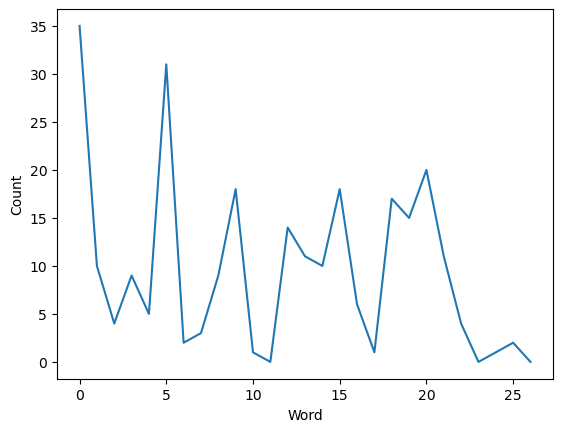

In [35]:
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

## Zipf's Law

An empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. 

Most frequent word : 958743 
Second Most frequent word : 945931 
Third Most frequent word : 934597


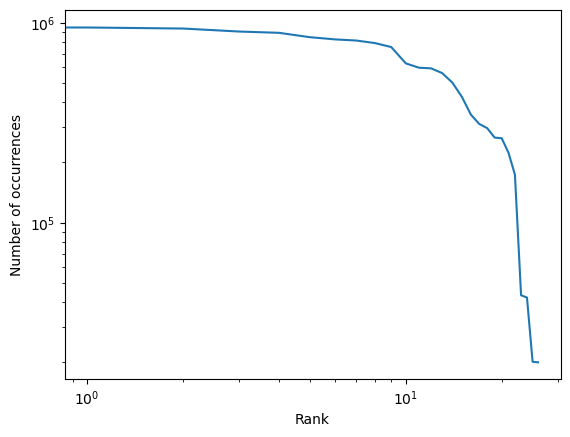

In [36]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]
print("Most frequent word : {} \nSecond Most frequent word : {} \nThird Most frequent word : {}".format(sorted_word_freq[0],sorted_word_freq[1],sorted_word_freq[2]))
# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()


### Normalizing the Bag of Words feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [37]:
import sklearn.preprocessing as pr

pr.normalize(features_train,)
pr.normalize(features_test,)
pr.normalize(features_test,)

array([[ 0.62655642,  0.26247634,  0.04233489, ...,  0.        ,
         0.04233489,  0.        ],
       [ 0.58116327,  0.30487254,  0.03810907, ...,  0.00952727,
         0.00952727,  0.        ],
       [ 0.58086712,  0.19097001,  0.03182834, ...,  0.02387125,
         0.03978542,  0.        ],
       ...,
       [-0.39799224,  0.24595026,  0.08496464, ...,  0.00447182,
         0.04024641,  0.        ],
       [ 0.66722595,  0.22826151,  0.01755858, ...,  0.00585286,
         0.05267573,  0.00585286],
       [ 0.61018897,  0.18079673,  0.0056499 , ...,  0.01694969,
         0.0112998 ,  0.        ]])